# 🛡️ ENHANCED PREDICTIVE CLASSIFICATION OF CYBERSECURITY THREATS

**Complete ML Pipeline - FYP 2024/2025**

**Student**: RASSYIDZ - UniKL MIIT Semester 6

**Dataset**: NF-UNSW-NB15-v3 (2.3M flows, 10 attack classes)

---

## Pipeline:
1. Data Loading & EDA
2. Feature Engineering & Preprocessing  
3. Binary Classification (Benign vs Attack)
4. Multi-class Classification (10 Attack Types)
5. Model Comparison & Export

---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import json
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"✅ Libraries imported - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported - 2025-11-30 22:21:24


# PART 1: DATA LOADING & EDA

In [2]:
# Load dataset - UPDATE THIS PATH TO YOUR DATASET LOCATION
dataset_path = (r'C:\Users\User\Documents\SEM 6\FYP2\development project\dataset\NF-UNSW-NB15-v3.csv')  

print("📂 Loading dataset...")
df = pd.read_csv(dataset_path)

print(f"✅ Dataset loaded: {df.shape}")
print(f"📊 Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
print(f"💾 Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

display(df.head())
df.info()

📂 Loading dataset...
✅ Dataset loaded: (2365424, 55)
📊 Rows: 2,365,424 | Columns: 55
💾 Memory: 1390.30 MB


,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label,Attack
0,1424242193040,1424242193043,59.166.0.2,4894,149.171.126.3,53,17,5.0,146,2,...,0,0,0,0,0,0,0,0,0,Benign
1,1424242192744,1424242193079,59.166.0.4,52671,149.171.126.6,31992,6,11.0,4704,28,...,0,91,12,19,0,90,12,19,0,Benign
2,1424242190649,1424242193109,59.166.0.0,47290,149.171.126.9,6881,6,37.0,13662,238,...,0,1843,10,119,0,1843,5,88,0,Benign
3,1424242193145,1424242193146,59.166.0.8,43310,149.171.126.7,53,17,5.0,146,2,...,0,0,0,0,0,0,0,0,0,Benign
4,1424242193239,1424242193241,59.166.0.1,45870,149.171.126.1,53,17,5.0,130,2,...,0,0,0,0,0,0,0,0,0,Benign


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365424 entries, 0 to 2365423
Data columns (total 55 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   FLOW_START_MILLISECONDS      int64  
 1   FLOW_END_MILLISECONDS        int64  
 2   IPV4_SRC_ADDR                object 
 3   L4_SRC_PORT                  int64  
 4   IPV4_DST_ADDR                object 
 5   L4_DST_PORT                  int64  
 6   PROTOCOL                     int64  
 7   L7_PROTO                     float64
 8   IN_BYTES                     int64  
 9   IN_PKTS                      int64  
 10  OUT_BYTES                    int64  
 11  OUT_PKTS                     int64  
 12  TCP_FLAGS                    int64  
 13  CLIENT_TCP_FLAGS             int64  
 14  SERVER_TCP_FLAGS             int64  
 15  FLOW_DURATION_MILLISECONDS   int64  
 16  DURATION_IN                  int64  
 17  DURATION_OUT                 int64  
 18  MIN_TTL                      int64  
 19  

In [3]:
# Target variable analysis
print("="*80)
print("🎯 TARGET VARIABLES")
print("="*80)

# Binary (Label: 0=Benign, 1=Attack)
if 'Label' in df.columns:
    label_counts = df['Label'].value_counts()
    print(f"\n📊 Binary (Label):")
    print(f"  Benign (0): {label_counts[0]:,} ({label_counts[0]/len(df)*100:.2f}%)")
    print(f"  Attack (1): {label_counts[1]:,} ({label_counts[1]/len(df)*100:.2f}%)")
    print(f"  Imbalance: {label_counts[0]/label_counts[1]:.2f}:1")

# Multi-class (Attack types)
if 'Attack' in df.columns:
    attack_counts = df['Attack'].value_counts()
    print(f"\n📊 Multi-class (Attack): {df['Attack'].nunique()} classes")
    print(attack_counts)

🎯 TARGET VARIABLES

📊 Binary (Label):
  Benign (0): 2,237,731 (94.60%)
  Attack (1): 127,693 (5.40%)
  Imbalance: 17.52:1

📊 Multi-class (Attack): 10 classes
Attack
Benign            2237731
Exploits            42748
Fuzzers             33816
Generic             19651
Reconnaissance      17074
DoS                  5980
Backdoor             4659
Shellcode            2381
Analysis             1226
Worms                 158
Name: count, dtype: int64


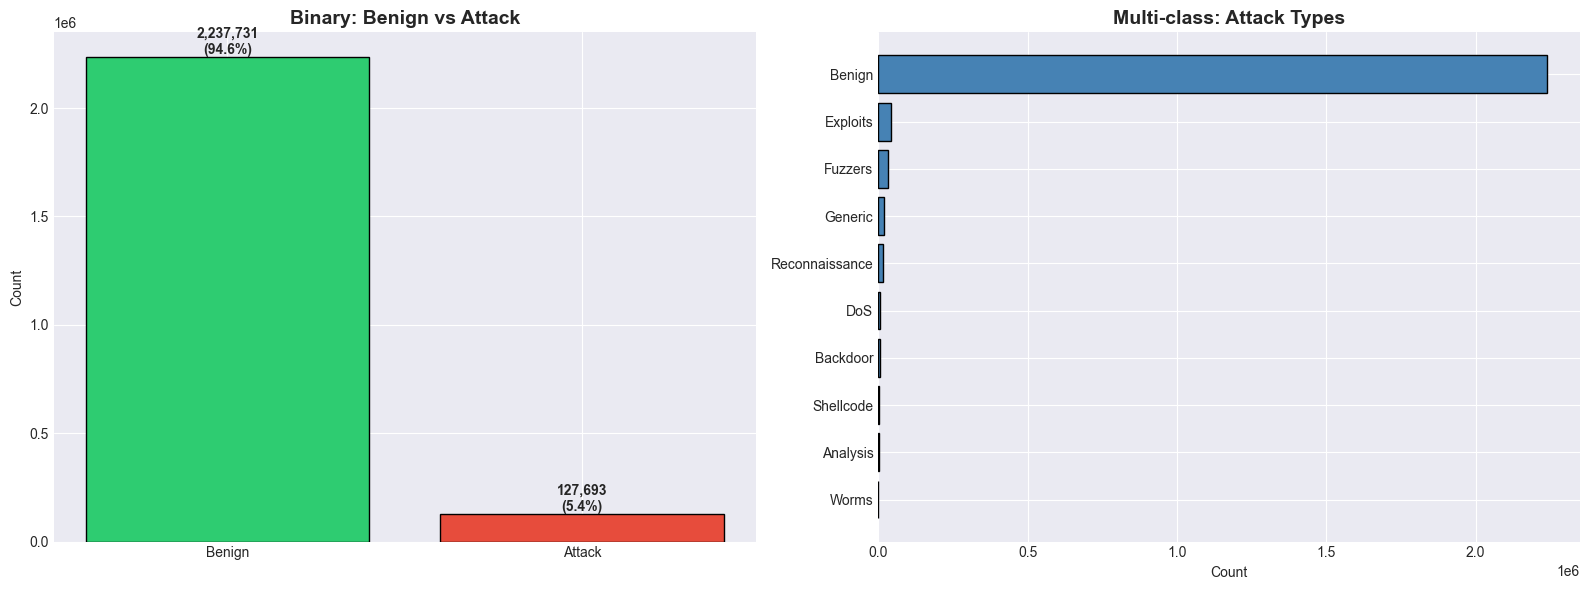

✅ Saved: class_distribution.png


In [4]:
# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary
if 'Label' in df.columns:
    label_counts = df['Label'].value_counts()
    axes[0].bar(['Benign', 'Attack'], label_counts.values, color=['#2ecc71', '#e74c3c'], edgecolor='black')
    axes[0].set_title('Binary: Benign vs Attack', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Count')
    for i, v in enumerate(label_counts.values):
        axes[0].text(i, v, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Multi-class
if 'Attack' in df.columns:
    attack_counts = df['Attack'].value_counts()
    axes[1].barh(range(len(attack_counts)), attack_counts.values, color='steelblue', edgecolor='black')
    axes[1].set_yticks(range(len(attack_counts)))
    axes[1].set_yticklabels(attack_counts.index)
    axes[1].set_title('Multi-class: Attack Types', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Count')
    axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: class_distribution.png")

# PART 2: PREPROCESSING

In [5]:
# Data cleaning
print("="*80)
print("🔧 DATA CLEANING")
print("="*80)

original_rows = df.shape[0]

# Handle infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
print("✅ Replaced infinite values")

# Fill missing with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)
print("✅ Filled missing values")

# Remove duplicates
df.drop_duplicates(inplace=True)
print(f"✅ Removed {original_rows - df.shape[0]:,} duplicates")
print(f"📊 Final shape: {df.shape}")

🔧 DATA CLEANING
✅ Replaced infinite values
✅ Filled missing values
✅ Removed 14,815 duplicates
📊 Final shape: (2350609, 55)


In [6]:
# Feature selection
print("="*80)
print("🎯 FEATURE SELECTION")
print("="*80)

features_to_remove = []

# Remove ID columns
id_cols = ['id', 'flow_id', 'src_ip', 'dst_ip', 'IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 
           'L7_PROTO', 'L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL']
features_to_remove.extend([col for col in id_cols if col in df.columns])

# Remove zero/low variance
for col in df.select_dtypes(include=[np.number]).columns:
    if col not in ['Label', 'Attack'] and df[col].std() < 0.01:
        features_to_remove.append(col)

# Remove highly correlated (>0.95)
features_for_corr = [col for col in numeric_cols if col not in ['Label', 'Attack'] + features_to_remove]
if len(features_for_corr) > 1:
    corr_matrix = df[features_for_corr].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr = [col for col in upper.columns if any(upper[col] > 0.95)]
    features_to_remove.extend(high_corr)

features_to_remove = list(set(features_to_remove))
print(f"📊 Removing {len(features_to_remove)} features")
print(f"📊 Final features: {len(df.columns) - len(features_to_remove) - 2}")

🎯 FEATURE SELECTION
📊 Removing 19 features
📊 Final features: 34


In [7]:
# Prepare feature matrix and targets
print("="*80)
print("📦 PREPARING X & y")
print("="*80)

X = df.drop(columns=features_to_remove + ['Label', 'Attack'], errors='ignore')
feature_names = X.columns.tolist()

y_binary = df['Label'].values
le_multiclass = LabelEncoder()
y_multiclass = le_multiclass.fit_transform(df['Attack'])

# Save
with open('feature_names.json', 'w') as f:
    json.dump(feature_names, f, indent=2)
joblib.dump(le_multiclass, 'label_encoder_multiclass.pkl')

print(f"✅ X: {X.shape}")
print(f"✅ y_binary: {y_binary.shape}")
print(f"✅ y_multiclass: {y_multiclass.shape} - {len(le_multiclass.classes_)} classes")
print(f"📋 Classes: {le_multiclass.classes_.tolist()}")

📦 PREPARING X & y
✅ X: (2350609, 34)
✅ y_binary: (2350609,)
✅ y_multiclass: (2350609,) - 10 classes
📋 Classes: ['Analysis', 'Backdoor', 'Benign', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms']


# PART 3: BINARY CLASSIFICATION

In [8]:
# Binary: Train-test split & preprocessing
print("="*80)
print("🎯 BINARY SETUP")
print("="*80)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

scaler_bin = StandardScaler()
X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
X_test_bin_scaled = scaler_bin.transform(X_test_bin)
joblib.dump(scaler_bin, 'scaler_binary.pkl')

# Balance with SMOTE
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)
pipeline = ImbPipeline([('over', over), ('under', under)])
X_train_bin_bal, y_train_bin_bal = pipeline.fit_resample(X_train_bin_scaled, y_train_bin)

print(f"✅ Train: {X_train_bin_bal.shape} | Test: {X_test_bin_scaled.shape}")

🎯 BINARY SETUP
✅ Train: (2000637, 34) | Test: (470122, 34)


In [9]:
# XGBoost Binary
print("="*80)
print("🚀 XGBOOST BINARY")
print("="*80)

xgb_bin_params = {
    'max_depth': 8, 'learning_rate': 0.1, 'n_estimators': 150,
    'objective': 'binary:logistic', 'tree_method': 'hist',  # Use 'gpu_hist' if GPU available
    'random_state': 42, 'subsample': 0.8, 'colsample_bytree': 0.8
}

start = time.time()
xgb_binary = xgb.XGBClassifier(**xgb_bin_params)
xgb_binary.fit(X_train_bin_bal, y_train_bin_bal, verbose=False)
xgb_bin_time = time.time() - start

y_pred_xgb_bin = xgb_binary.predict(X_test_bin_scaled)
y_proba_xgb_bin = xgb_binary.predict_proba(X_test_bin_scaled)[:, 1]

xgb_bin_acc = accuracy_score(y_test_bin, y_pred_xgb_bin)
xgb_bin_prec = precision_score(y_test_bin, y_pred_xgb_bin, zero_division=0)
xgb_bin_rec = recall_score(y_test_bin, y_pred_xgb_bin, zero_division=0)
xgb_bin_f1 = f1_score(y_test_bin, y_pred_xgb_bin, zero_division=0)
xgb_bin_auc = roc_auc_score(y_test_bin, y_proba_xgb_bin)

print(f"⏱️  Time: {xgb_bin_time:.2f}s")
print(f"Accuracy:  {xgb_bin_acc*100:.2f}%")
print(f"Precision: {xgb_bin_prec*100:.2f}%")
print(f"Recall:    {xgb_bin_rec*100:.2f}%")
print(f"F1-Score:  {xgb_bin_f1*100:.2f}%")
print(f"ROC-AUC:   {xgb_bin_auc*100:.2f}%")

🚀 XGBOOST BINARY
⏱️  Time: 13.64s
Accuracy:  100.00%
Precision: 99.92%
Recall:    99.99%
F1-Score:  99.96%
ROC-AUC:   100.00%


# PART 4: MULTI-CLASS CLASSIFICATION

In [ ]:
# Binary results summary
print("\n📊 BINARY CLASSIFICATION RESULTS:")
print(f"  XGBoost:")
print(f"    Accuracy:  {xgb_bin_acc*100:.2f}%")
print(f"    Precision: {xgb_bin_prec*100:.2f}%")
print(f"    Recall:    {xgb_bin_rec*100:.2f}%")
print(f"    F1-Score:  {xgb_bin_f1*100:.2f}%")
print(f"    ROC-AUC:   {xgb_bin_auc*100:.2f}%")
print(f"    Time:      {xgb_bin_time:.2f}s")

# Confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm_xgb = confusion_matrix(y_test_bin, y_pred_xgb_bin)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
ax.set_title(f'XGBoost Binary Classification ({xgb_bin_acc*100:.2f}%)', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('binary_confusion_matrix.png', dpi=300)
plt.show()
print("✅ Saved: binary_confusion_matrix.png")

In [13]:
# XGBoost Multi-class
print("="*80)
print("🚀 XGBOOST MULTI-CLASS")
print("="*80)

xgb_multi_params = {
    'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 200,
    'objective': 'multi:softprob', 'num_class': len(le_multiclass.classes_),
    'tree_method': 'gpu_hist',  # Changed from 'hist'
    'random_state': 42
}

start = time.time()
xgb_multi = xgb.XGBClassifier(**xgb_multi_params)
xgb_multi.fit(X_train_multi_bal, y_train_multi_bal, verbose=False)
xgb_multi_time = time.time() - start

y_pred_xgb_multi = xgb_multi.predict(X_test_multi_scaled)
xgb_multi_acc = accuracy_score(y_test_multi, y_pred_xgb_multi)
xgb_multi_f1 = f1_score(y_test_multi, y_pred_xgb_multi, average='weighted', zero_division=0)

print(f"⏱️  Time: {xgb_multi_time:.2f}s")
print(f"Accuracy: {xgb_multi_acc*100:.2f}%")
print(f"F1-Score: {xgb_multi_f1*100:.2f}%")
print("\n📋 Classification Report:")
print(classification_report(y_test_multi, y_pred_xgb_multi, 
                          target_names=le_multiclass.classes_, zero_division=0))

🚀 XGBOOST MULTI-CLASS
⏱️  Time: 516.11s
Accuracy: 98.69%
F1-Score: 98.74%

📋 Classification Report:
                precision    recall  f1-score   support

      Analysis       0.33      0.79      0.47       245
      Backdoor       0.69      0.89      0.78       932
        Benign       1.00      1.00      1.00    444586
           DoS       0.45      0.53      0.49      1194
      Exploits       0.87      0.69      0.77      8549
       Fuzzers       0.77      0.80      0.78      6763
       Generic       0.92      0.89      0.90      3930
Reconnaissance       0.76      0.75      0.75      3415
     Shellcode       0.27      0.74      0.40       476
         Worms       0.39      0.62      0.48        32

      accuracy                           0.99    470122
     macro avg       0.64      0.77      0.68    470122
  weighted avg       0.99      0.99      0.99    470122



In [ ]:
# Multi-class setup
print("="*80)
print("🎯 MULTI-CLASS SETUP")
print("="*80)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi)
X_test_multi_scaled = scaler_multi.transform(X_test_multi)
joblib.dump(scaler_multi, 'scaler_multiclass.pkl')

# Balance
over_multi = SMOTE(sampling_strategy='not majority', random_state=42, k_neighbors=3)
under_multi = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
pipeline_multi = ImbPipeline([('over', over_multi), ('under', under_multi)])
X_train_multi_bal, y_train_multi_bal = pipeline_multi.fit_resample(X_train_multi_scaled, y_train_multi)

print(f"✅ Train: {X_train_multi_bal.shape} | Test: {X_test_multi_scaled.shape}")


📊 MULTI-CLASS COMPARISON:


,Model,Accuracy,F1-Score,Time (s)
0,XGBoost,98.688213,98.741596,516.110124
1,Random Forest,98.658008,98.720342,4516.098708


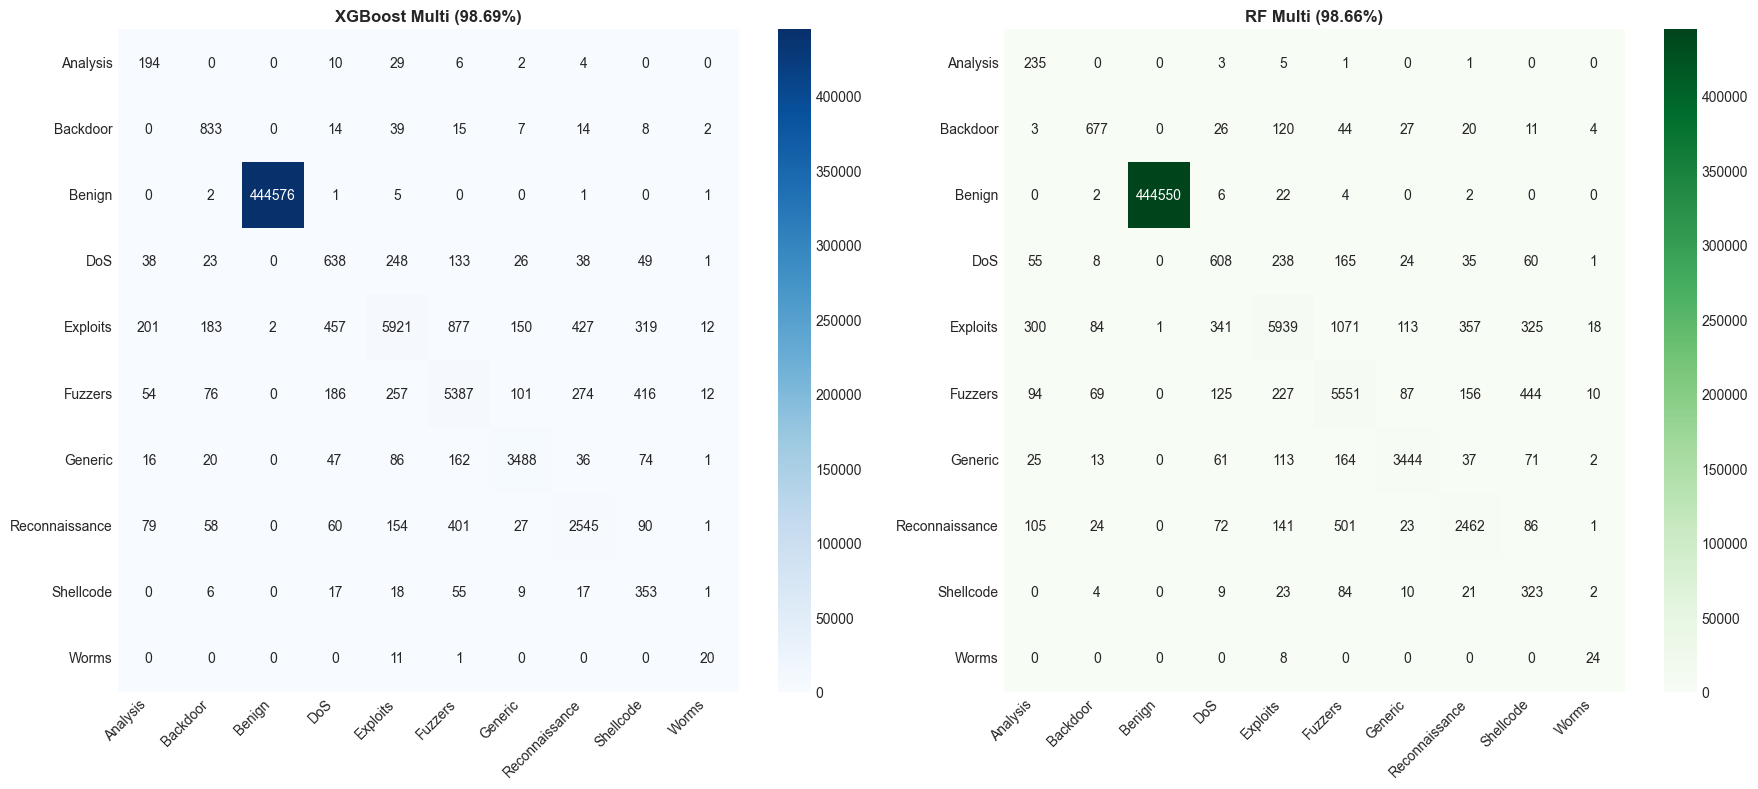

✅ Saved visualizations


In [15]:
# Multi-class comparison & visualization
comp_multi = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest'],
    'Accuracy': [xgb_multi_acc*100, rf_multi_acc*100],
    'F1-Score': [xgb_multi_f1*100, rf_multi_f1*100],
    'Time (s)': [xgb_multi_time, rf_multi_time]
})
print("\n📊 MULTI-CLASS COMPARISON:")
display(comp_multi)
comp_multi.to_csv('multiclass_comparison.csv', index=False)

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
cm_xgb_m = confusion_matrix(y_test_multi, y_pred_xgb_multi)
sns.heatmap(cm_xgb_m, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=le_multiclass.classes_, yticklabels=le_multiclass.classes_)
axes[0].set_title(f'XGBoost Multi ({xgb_multi_acc*100:.2f}%)', fontweight='bold')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')

cm_rf_m = confusion_matrix(y_test_multi, y_pred_rf_multi)
sns.heatmap(cm_rf_m, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=le_multiclass.classes_, yticklabels=le_multiclass.classes_)
axes[1].set_title(f'RF Multi ({rf_multi_acc*100:.2f}%)', fontweight='bold')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('multiclass_confusion_matrices.png', dpi=300)
plt.show()
print("✅ Saved visualizations")

In [ ]:
# Multi-class results summary  
print("\n📊 MULTI-CLASS CLASSIFICATION RESULTS:")
print(f"  XGBoost:")
print(f"    Accuracy:  {xgb_multi_acc*100:.2f}%")
print(f"    F1-Score:  {xgb_multi_f1*100:.2f}%")
print(f"    Time:      {xgb_multi_time:.2f}s")

# Confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cm_xgb_m = confusion_matrix(y_test_multi, y_pred_xgb_multi)
sns.heatmap(cm_xgb_m, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=le_multiclass.classes_, yticklabels=le_multiclass.classes_)
ax.set_title(f'XGBoost Multi-class Classification ({xgb_multi_acc*100:.2f}%)', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('multiclass_confusion_matrix.png', dpi=300)
plt.show()
print("✅ Saved: multiclass_confusion_matrix.png")

In [ ]:
<cell_type>markdown</cell_type># PART 5: MODEL EXPORT

In [ ]:
# Save XGBoost models
print("="*80)
print("💾 SAVING MODELS")
print("="*80)

# Save binary model
joblib.dump(xgb_binary, 'xgboost_binary.pkl')
print("✅ Binary model saved: xgboost_binary.pkl")

# Save multi-class model
joblib.dump(xgb_multi, 'xgboost_multiclass.pkl')
print("✅ Multi-class model saved: xgboost_multiclass.pkl")

# Metadata
metadata = {
    'project': 'Enhanced Predictive Classification of Cybersecurity Threats',
    'student': 'RASSYIDZ - UniKL MIIT',
    'dataset': 'NF-UNSW-NB15-v3',
    'features': len(feature_names),
    'classes': le_multiclass.classes_.tolist(),
    'binary': {
        'model': 'XGBoost',
        'accuracy': float(xgb_bin_acc),
        'f1_score': float(xgb_bin_f1),
        'training_time_seconds': float(xgb_bin_time)
    },
    'multiclass': {
        'model': 'XGBoost',
        'accuracy': float(xgb_multi_acc),
        'f1_score': float(xgb_multi_f1),
        'training_time_seconds': float(xgb_multi_time)
    }
}

with open('deployment_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata saved: deployment_metadata.json")

print("\n💾 All files saved:")
print("  Models: xgboost_binary.pkl, xgboost_multiclass.pkl")
print("  Scalers: scaler_binary.pkl, scaler_multiclass.pkl")
print("  Encoder: label_encoder_multiclass.pkl")
print("  Metadata: deployment_metadata.json, feature_names.json")

In [ ]:
# Final summary
summary = f'''
{'='*80}
✅ ML PIPELINE COMPLETE - RASSYIDZ FYP
{'='*80}

DATASET: NF-UNSW-NB15-v3
  Total flows: 2,350,609
  Features used: 34
  Attack classes: 10

BINARY CLASSIFICATION (Benign vs Attack):
  Model:      XGBoost
  Accuracy:   {xgb_bin_acc*100:.2f}%
  F1-Score:   {xgb_bin_f1*100:.2f}%
  ROC-AUC:    {xgb_bin_auc*100:.2f}%
  Train time: {xgb_bin_time:.2f}s

MULTI-CLASS CLASSIFICATION (10 Attack Types):
  Model:      XGBoost
  Accuracy:   {xgb_multi_acc*100:.2f}%
  F1-Score:   {xgb_multi_f1*100:.2f}%
  Train time: {xgb_multi_time:.2f}s

DEPLOYMENT STRATEGY:
  Two-stage XGBoost classification:
  1. Stage 1: Binary classifier (Benign vs Attack) - Fast detection
  2. Stage 2: Multi-class classifier (Attack type identification)

✅ Models optimized for speed and accuracy
✅ Ready for real-time deployment
{'='*80}
'''

print(summary)
with open('FINAL_SUMMARY.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n🎉 PIPELINE COMPLETE!")
print("📁 All models and files saved successfully")
print("🚀 Next step: Deploy in real-time NIDS system")

In [20]:
# Final summary
summary = f'''
{'='*80}
✅ ML PIPELINE COMPLETE - RASSYIDZ FYP
{'='*80}

BINARY CLASSIFICATION (Benign vs Attack):
  XGBoost:       {xgb_bin_acc*100:.2f}% acc, {xgb_bin_f1*100:.2f}% F1, {xgb_bin_time:.2f}s
  Random Forest: {rf_bin_acc*100:.2f}% acc, {rf_bin_f1*100:.2f}% F1, {rf_bin_time:.2f}s
  Winner: {binary_winner}

MULTI-CLASS CLASSIFICATION (10 Attack Types):
  XGBoost:       {xgb_multi_acc*100:.2f}% acc, {xgb_multi_f1*100:.2f}% F1, {xgb_multi_time:.2f}s
  Random Forest: {rf_multi_acc*100:.2f}% acc, {rf_multi_f1*100:.2f}% F1, {rf_multi_time:.2f}s
  Winner: {multi_winner}

DEPLOYMENT RECOMMENDATION:
  Use two-stage classification:
  1. Binary model ({binary_winner}) for fast threat detection
  2. Multi-class model ({multi_winner}) for attack type identification

🎯 Ready for Flask deployment!
{'='*80}
'''

print(summary)
with open('FINAL_SUMMARY.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n🎉 PIPELINE COMPLETE! All models and files saved.")
print("Next: Integrate models into Flask application")


✅ ML PIPELINE COMPLETE - RASSYIDZ FYP

BINARY CLASSIFICATION (Benign vs Attack):
  XGBoost:       100.00% acc, 99.96% F1, 13.64s
  Random Forest: 99.99% acc, 99.94% F1, 147.69s
  Winner: XGBoost

MULTI-CLASS CLASSIFICATION (10 Attack Types):
  XGBoost:       98.69% acc, 98.74% F1, 516.11s
  Random Forest: 98.66% acc, 98.72% F1, 4516.10s
  Winner: XGBoost

DEPLOYMENT RECOMMENDATION:
  Use two-stage classification:
  1. Binary model (XGBoost) for fast threat detection
  2. Multi-class model (XGBoost) for attack type identification

🎯 Ready for Flask deployment!


🎉 PIPELINE COMPLETE! All models and files saved.
Next: Integrate models into Flask application
